In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pickle
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SelectFromModel, RFE, RFECV
from collections import defaultdict

ECG_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_ECG-only.csv").drop(columns = "ID")
EDA_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EDA-only.csv").drop(columns = "ID")
EEG_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EEG-only.csv").drop(columns = "ID")
EYE_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_EYE-only.csv").drop(columns = "ID").replace([np.inf, -np.inf], np.nan).interpolate()
fNIRS_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_fNIRS-only.csv").drop(columns = "ID")
RSP_df = pd.read_csv("./Data by Sensor/kieranFeatures_1-30_24-Oct-2024_RSP-only.csv").drop(columns = "ID")

In [70]:
# Isolate the outcomes variables
outcomes_df = ECG_df.iloc[:, ECG_df.shape[1] - 4:]
outcomes_df_shuffled = ECG_df.iloc[:, ECG_df.shape[1] - 4:]

# Create binary variables for high and low 
adj_SA_1_median = np.median(outcomes_df["adjSA1"])
adj_SA_2_median = np.median(outcomes_df["adjSA2"])
adj_SA_3_median = np.median(outcomes_df["adjSA3"])
adj_SA_tot_median = np.median(outcomes_df["adjSAtotal"])

# Will be high if adjusted SA level score is equal to or above median, low otherwise
outcomes_df["Lv_1_Hi"] = (outcomes_df["adjSA1"] >= adj_SA_1_median).astype(int)
outcomes_df["Lv_2_Hi"] = (outcomes_df["adjSA2"] >= adj_SA_2_median).astype(int)
outcomes_df["Lv_3_Hi"] = (outcomes_df["adjSA3"] >= adj_SA_3_median).astype(int)
outcomes_df["Tot_Hi"] = (outcomes_df["adjSAtotal"] >= adj_SA_tot_median).astype(int)

# Will be high if adjusted SA level score is equal to or above median, low otherwise
outcomes_df_shuffled["Lv_1_Hi"] = np.random.permutation((outcomes_df_shuffled["adjSA1"] >= adj_SA_1_median).astype(int))
outcomes_df_shuffled["Lv_2_Hi"] = np.random.permutation((outcomes_df_shuffled["adjSA2"] >= adj_SA_2_median).astype(int))
outcomes_df_shuffled["Lv_3_Hi"] = np.random.permutation((outcomes_df_shuffled["adjSA3"] >= adj_SA_3_median).astype(int))
outcomes_df_shuffled["Tot_Hi"] = np.random.permutation((outcomes_df_shuffled["adjSAtotal"] >= adj_SA_tot_median).astype(int))

# Remove outcomes variables from each sensor dataframe
ECG_df = ECG_df.iloc[:, :ECG_df.shape[1] - 4]
EDA_df = EDA_df.iloc[:, :EDA_df.shape[1] - 4]
EEG_df = EEG_df.iloc[:, :EEG_df.shape[1] - 4]
EYE_df = EYE_df.iloc[:, :EYE_df.shape[1] - 4]
fNIRS_df = fNIRS_df.iloc[:, :fNIRS_df.shape[1] - 4]
RSP_df = RSP_df.iloc[:, :RSP_df.shape[1] - 4]

# Free Memory
del adj_SA_1_median
del adj_SA_2_median
del adj_SA_3_median
del adj_SA_tot_median

In [71]:
sensor_map = {
    0: "ECG",
    1: "EDA",
    2: "EEG",
    3: "EYE",
    4: "fNIRS",
    5: "RSP"
}

# Load Test Scores and CV Models from File
with open("model_by_sensor.pkl", "rb") as f:
    all_sensor_test_scores, all_sensor_CV_models = pickle.load(f)

with open("shuffled_model_by_sensor.pkl", "rb") as f:
    all_sensor_test_scores_shuffled, all_sensor_CV_models_shuffled = pickle.load(f)

In [72]:
def graph_folds(all_sensor_test_scores, all_sensor_test_scores_shuffled, outcome_var):
    for i in range(6):
        width = 0.3
        x_vals = np.arange(1, 6)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_figheight(5)
        fig.set_figwidth(20)
        sensor_test_scores = all_sensor_test_scores[i][outcome_var]
        sensor_test_scores_shuffled = all_sensor_test_scores_shuffled[i][outcome_var]

        # AX 1 Graph
        # No Penalty Bars
        ax1.bar(x_vals - width, sensor_test_scores["Regular"], width, label = "No Penalty")
        for j in x_vals - 1:
            ax1.text(j - width + 1, sensor_test_scores["Regular"][j], round(sensor_test_scores["Regular"][j], 3), ha = "center")
            
        # Ridge Bars
        ax1.bar(x_vals, sensor_test_scores["Ridge"], width, label = "Ridge")
        for j in x_vals - 1:
            ax1.text(j + 1, sensor_test_scores["Ridge"][j], round(sensor_test_scores["Ridge"][j], 3), ha = "center")

        # LASSO Bars
        ax1.bar(x_vals + width, sensor_test_scores["LASSO"], width, label = "LASSO")
        for j in x_vals - 1:
            ax1.text(j + width + 1, sensor_test_scores["LASSO"][j], round(sensor_test_scores["LASSO"][j], 3), ha = "center")

        # 0.5 Line
        ax1.axhline(y = 0.5, color = "r")

        ax1.set_ylim([0.3, 0.7])
        ax1.set_xlabel("Test Fold")
        ax1.set_ylabel("Accuracy Score")
        ax1.set_title(sensor_map[i] + " Test Fold Accuracy Scores for " + outcome_var)
        ax1.legend(loc = "lower right")


        
        # AX 2 Graph
        # No Penalty Bars
        ax2.bar(x_vals - width, sensor_test_scores_shuffled["Regular"], width, label = "No Penalty")
        for j in x_vals - 1:
            ax2.text(j - width + 1, sensor_test_scores_shuffled["Regular"][j], round(sensor_test_scores_shuffled["Regular"][j], 3), ha = "center")
            
        # Ridge Bars
        ax2.bar(x_vals, sensor_test_scores_shuffled["Ridge"], width, label = "Ridge")
        for j in x_vals - 1:
            ax2.text(j + 1, sensor_test_scores_shuffled["Ridge"][j], round(sensor_test_scores_shuffled["Ridge"][j], 3), ha = "center")

        # LASSO Bars
        ax2.bar(x_vals + width, sensor_test_scores_shuffled["LASSO"], width, label = "LASSO")
        for j in x_vals - 1:
            ax2.text(j + width + 1, sensor_test_scores_shuffled["LASSO"][j], round(sensor_test_scores_shuffled["LASSO"][j], 3), ha = "center")

        # 0.5 Line
        ax2.axhline(y = 0.5, color = "r")

        ax2.set_ylim([0.3, 0.7])
        ax2.set_xlabel("Test Fold")
        ax2.set_ylabel("Accuracy Score")
        ax2.set_title("Shuffled " + sensor_map[i] + " Test Fold Accuracy Scores for " + outcome_var)
        ax2.legend(loc = "lower right")

        plt.show()

# SA 1

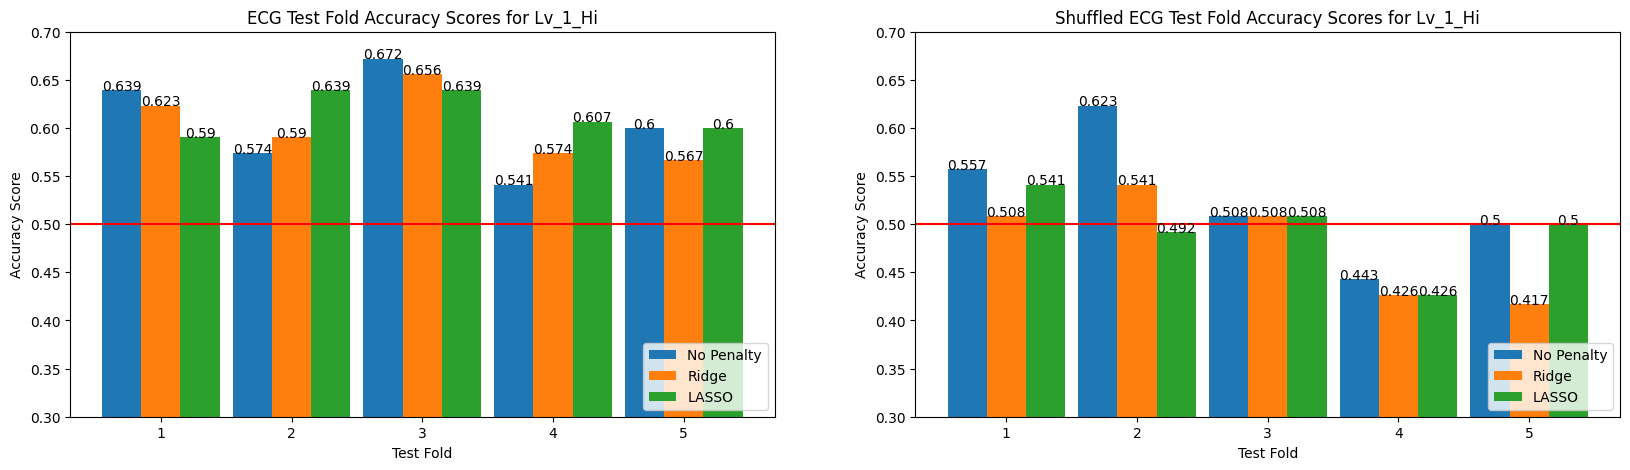

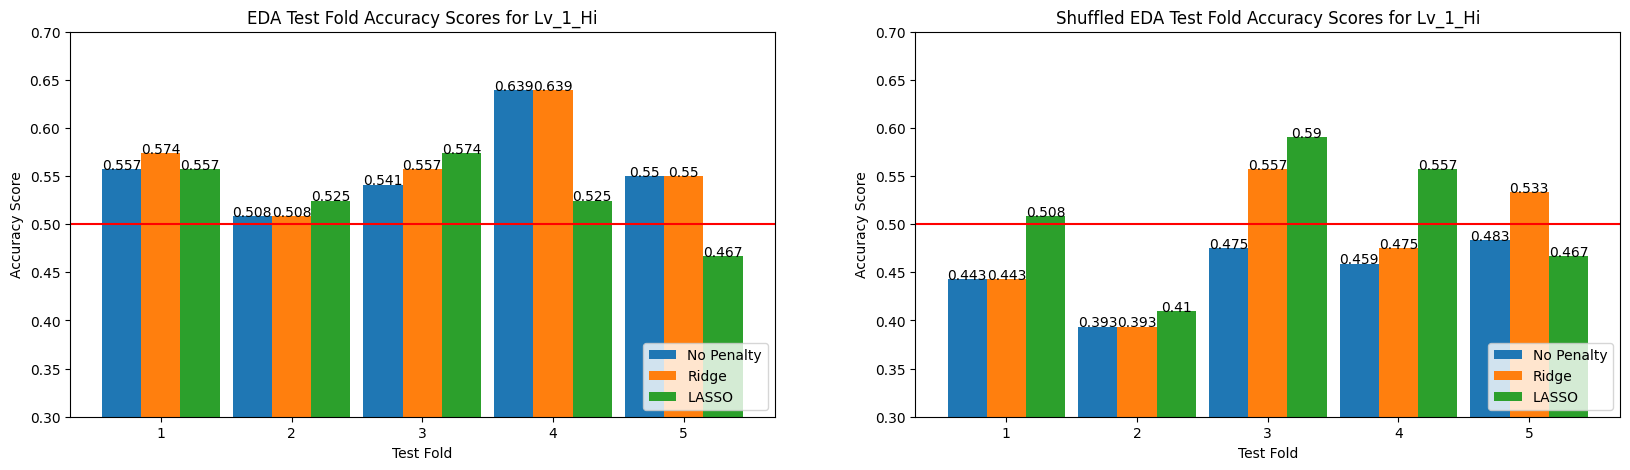

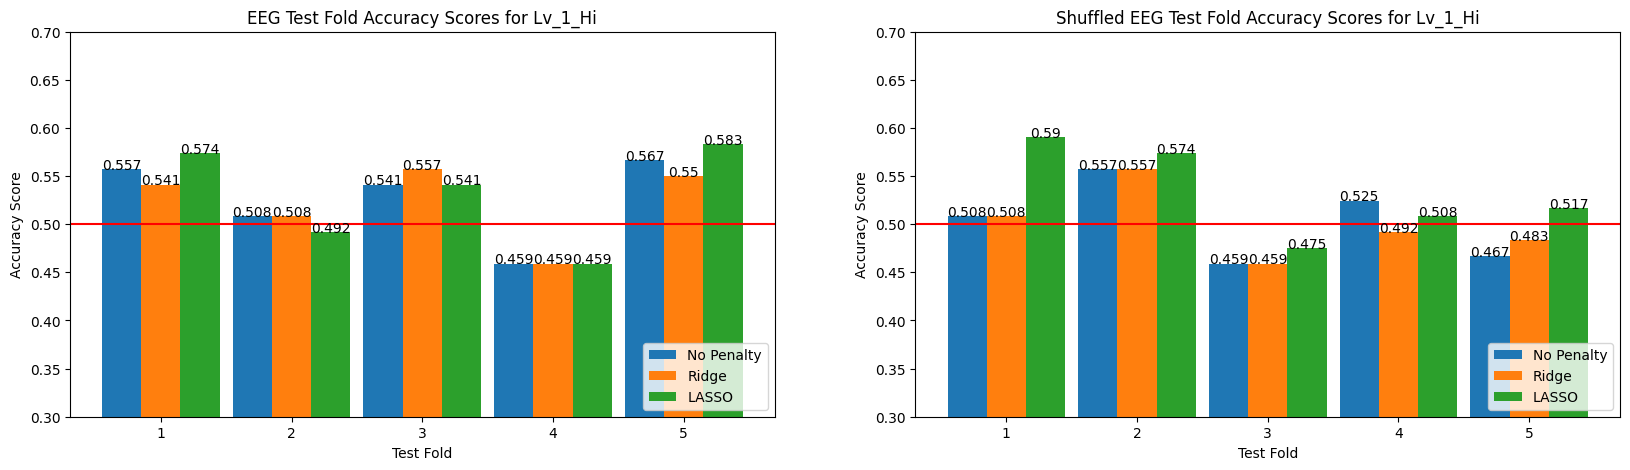

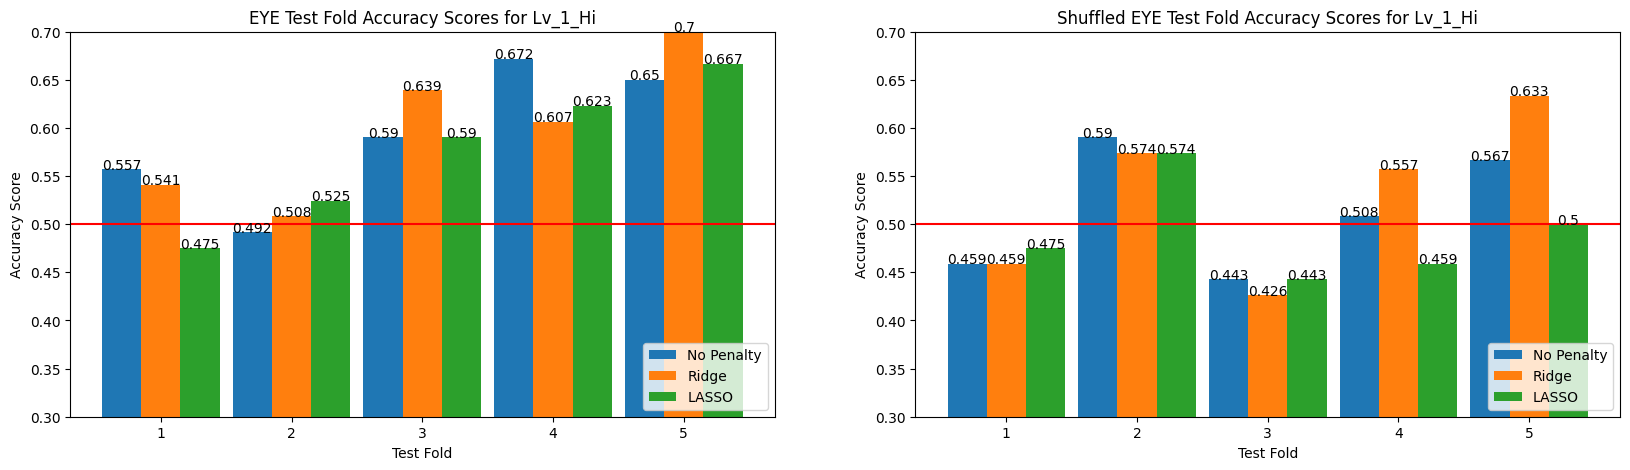

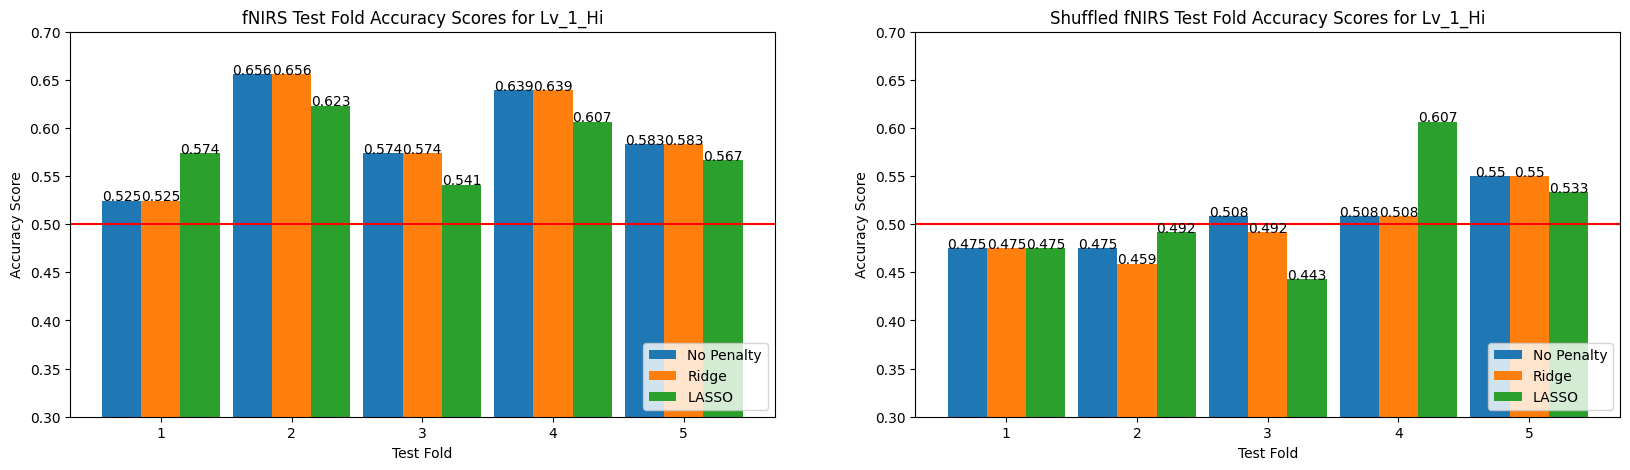

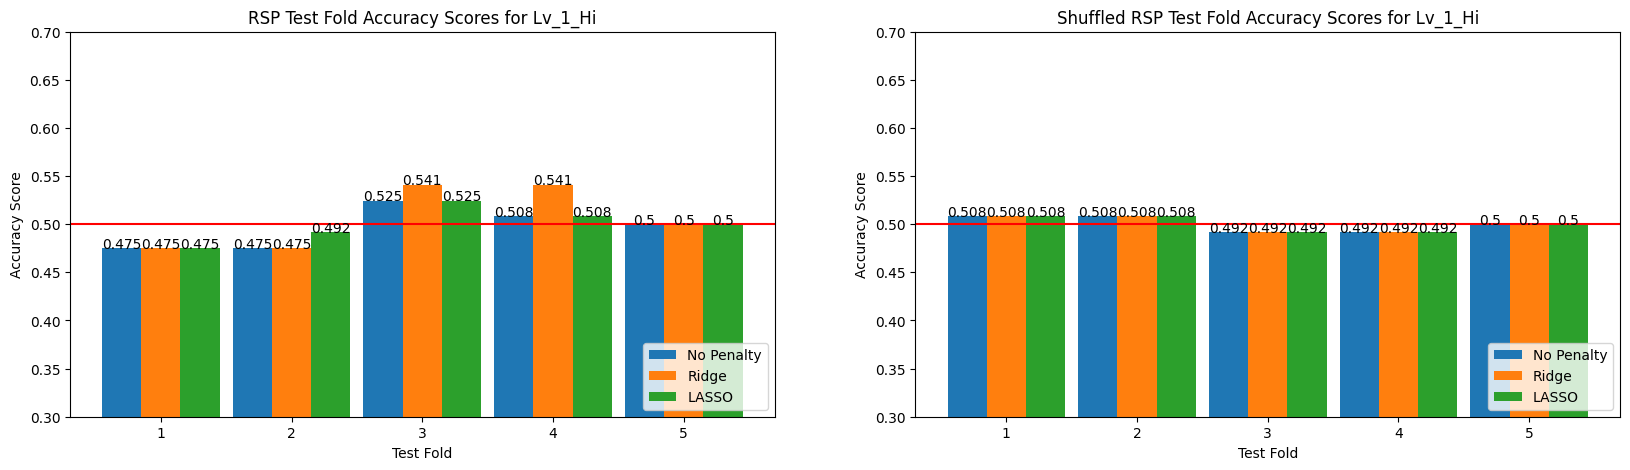

In [21]:
graph_folds(all_sensor_test_scores, all_sensor_test_scores_shuffled, "Lv_1_Hi")

# SA 2

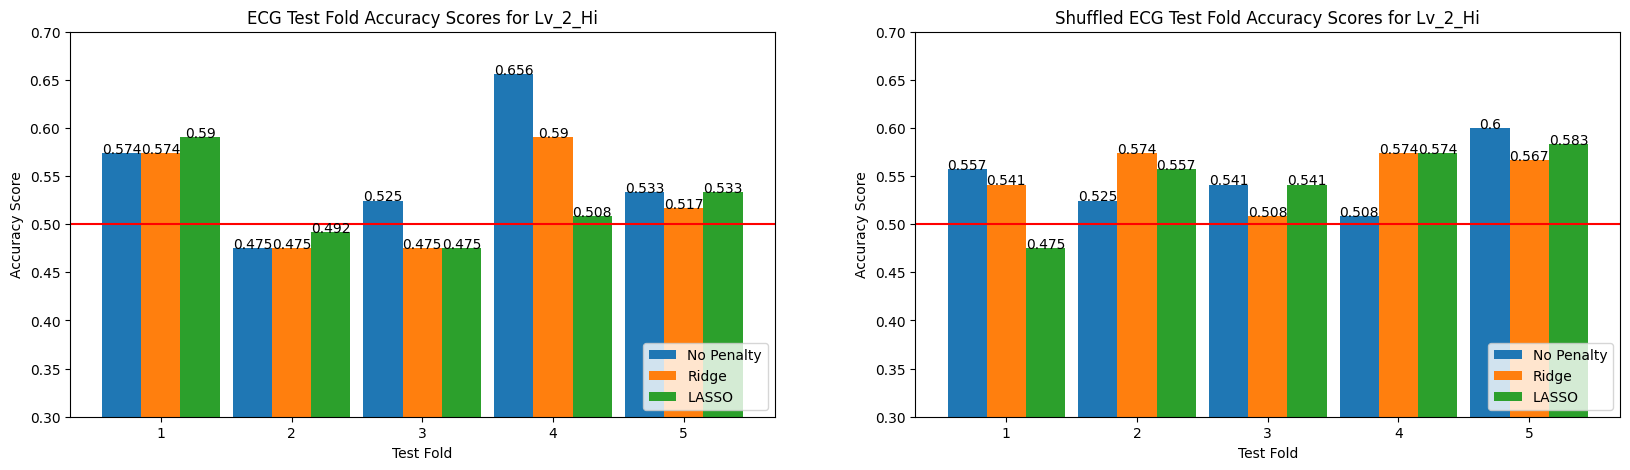

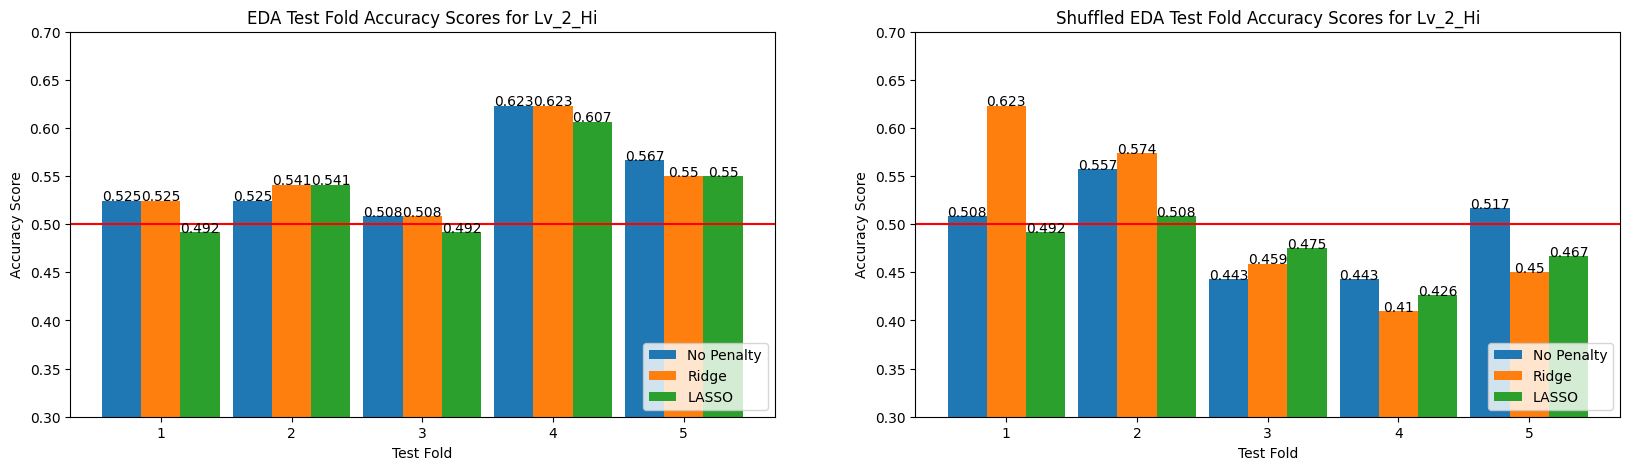

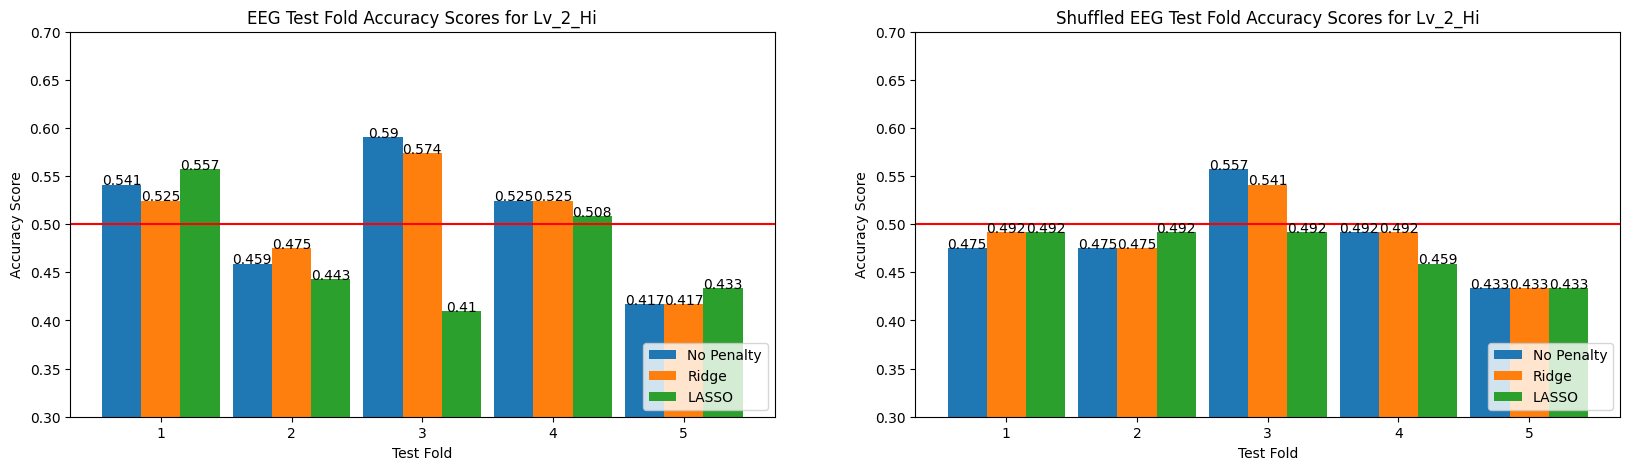

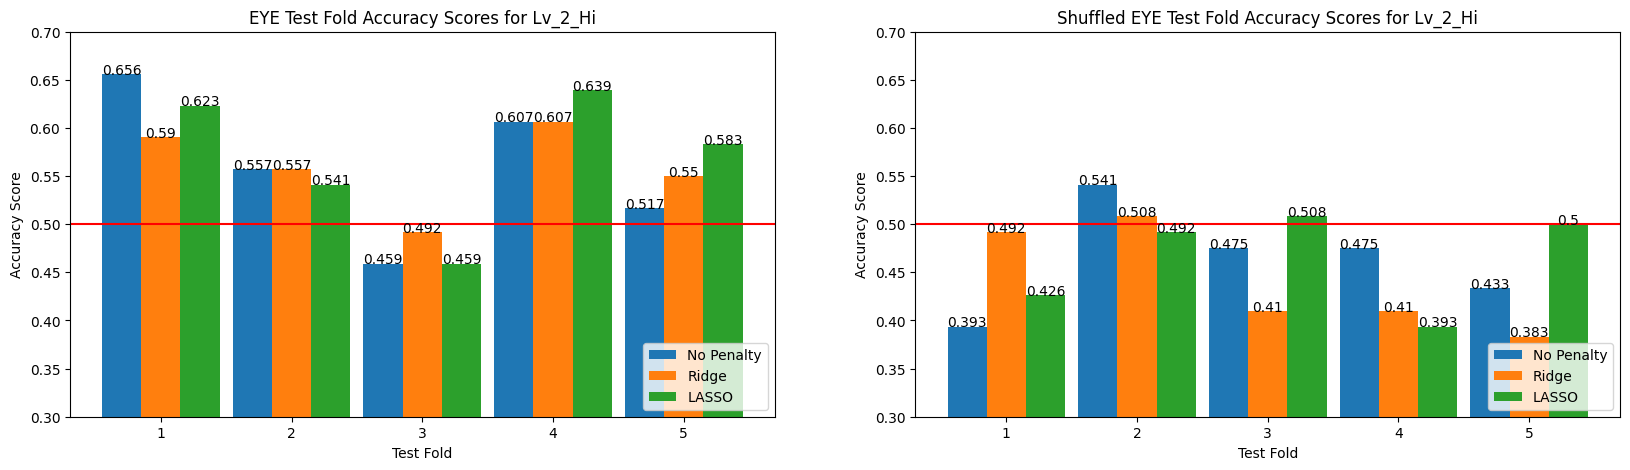

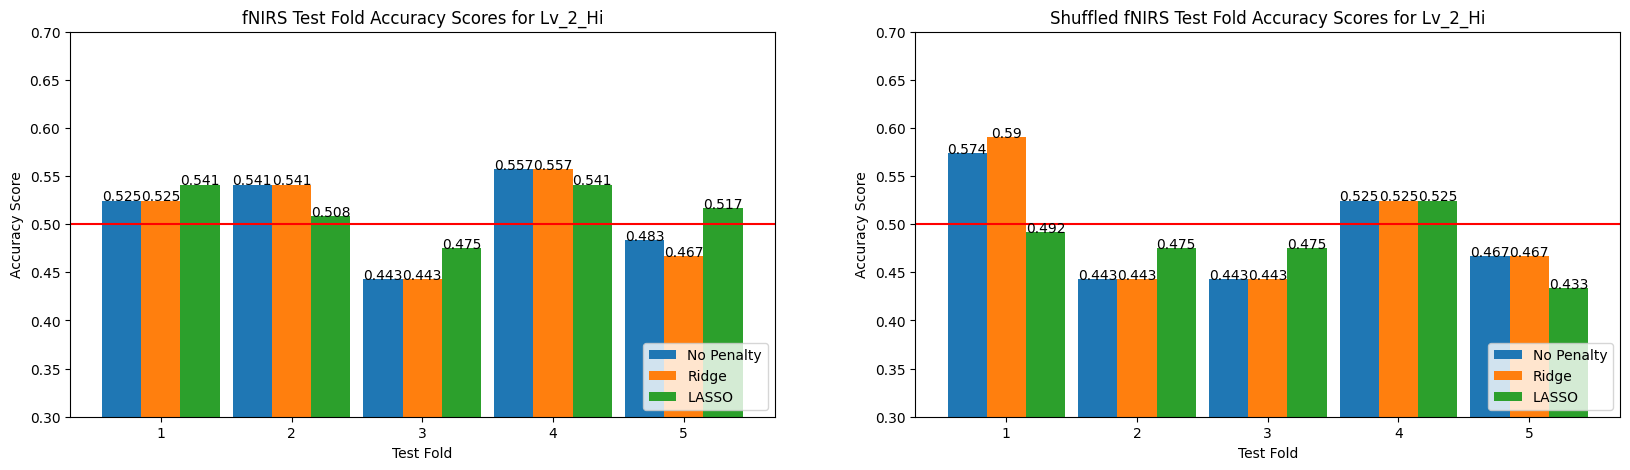

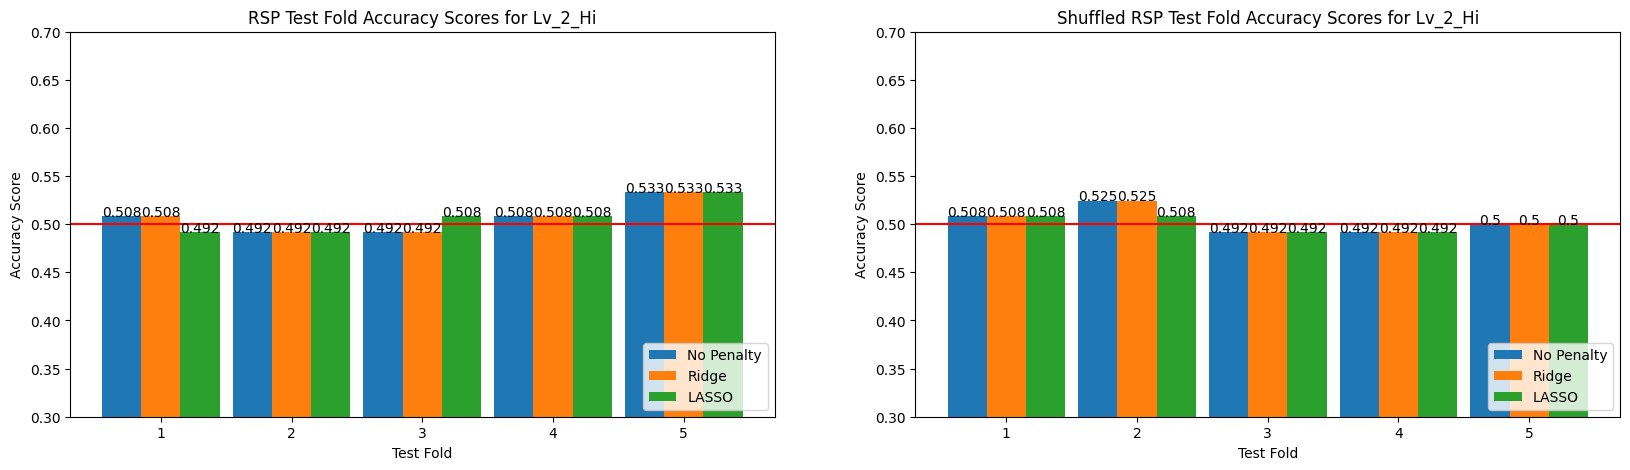

In [77]:
graph_folds(all_sensor_test_scores, all_sensor_test_scores_shuffled, "Lv_2_Hi")

In [ ]:
for model in all_sensor_CV_models[0]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[0]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

47
49
1
0
48
9
['ECG_SDNN_version02' 'ECG_SDNN_version03' 'ECG_SDNN_version04'
 'ECG_SDNN_version05' 'ECG_SDNN_version09' 'ECG_SDNN_version10'
 'ECG_Heartrate_version03' 'ECG_Heartrate_version10' 'ECG_RMSSD_version03']
19
['ECG_SDNN_version02' 'ECG_SDNN_version03' 'ECG_SDNN_version04'
 'ECG_SDNN_version05' 'ECG_SDNN_version09' 'ECG_SDNN_version10'
 'ECG_SDNN_version20' 'ECG_Heartrate_version03' 'ECG_Heartrate_version04'
 'ECG_Heartrate_version09' 'ECG_Heartrate_version20' 'ECG_RMSSD_version02'
 'ECG_RMSSD_version03' 'ECG_RMSSD_version04' 'ECG_RMSSD_version05'
 'ECG_RMSSD_version09' 'ECG_RMSSD_version10' 'ECG_RMSSD_version19'
 'ECG_RMSSD_version20']
19
['ECG_SDNN_version02' 'ECG_SDNN_version03' 'ECG_SDNN_version05'
 'ECG_SDNN_version09' 'ECG_SDNN_version10' 'ECG_SDNN_version19'
 'ECG_SDNN_version20' 'ECG_Heartrate_version02' 'ECG_Heartrate_version05'
 'ECG_Heartrate_version10' 'ECG_Heartrate_version20' 'ECG_RMSSD_version02'
 'ECG_RMSSD_version03' 'ECG_RMSSD_version04' 'ECG_RMSSD_version

In [29]:
for model in all_sensor_CV_models[1]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[1]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

88
72
88
109
122

0
4
76
3
22


In [30]:
for model in all_sensor_CV_models[2]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[2]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

18
18
4
0
80

200
0
44
204
47


In [31]:
for model in all_sensor_CV_models[3]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[3]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

6
11
87
29
7

5
0
0
89
0


In [32]:
for model in all_sensor_CV_models[4]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[4]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

762
755
468
433
1566

1528
319
707
770
263


In [34]:
for model in all_sensor_CV_models[5]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))
    print(np.array(RSP_df.columns)[np.array(model.coef_ != 0)[0]])

print()

for model in all_sensor_CV_models_shuffled[5]["Lv_2_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))
    print(np.array(RSP_df.columns)[np.array(model.coef_ != 0)[0]])

2
['RSP_TV_version11' 'RSP_TV_version12']
2
['RSP_TV_version11' 'RSP_TV_version12']
2
['RSP_TV_version11' 'RSP_TV_version12']
2
['RSP_TV_version11' 'RSP_TV_version12']
10
['RSP_TV_version02' 'RSP_TV_version04' 'RSP_TV_version05'
 'RSP_TV_version12' 'RSP_MV_version02' 'RSP_MV_version03'
 'RSP_MV_version04' 'RSP_MV_version05' 'RSP_MV_version19'
 'RSP_MV_version20']

2
['RSP_TV_version11' 'RSP_TV_version12']
1
['RSP_TV_version12']
2
['RSP_TV_version11' 'RSP_TV_version12']
11
['RSP_TV_version02' 'RSP_TV_version03' 'RSP_TV_version04'
 'RSP_TV_version05' 'RSP_TV_version11' 'RSP_TV_version12'
 'RSP_TV_version20' 'RSP_MV_version02' 'RSP_MV_version03'
 'RSP_MV_version04' 'RSP_MV_version05']
2
['RSP_TV_version11' 'RSP_TV_version12']


In [29]:
SA_2_sensor_predictions = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

SA_2_sensor_predictions_shuffled = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

In [ ]:
SA_2_sensor_predictions = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

SA_2_sensor_predictions_shuffled = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

In [ ]:
# Gather predictions for each fold
model_type = "LASSO"
outcome_var = "Lv_2_Hi"
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df[outcome_var])):
    # Append predictions for test fold
    SA_2_sensor_predictions["ECG"].append(all_sensor_CV_models[0][outcome_var][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["EDA"].append(all_sensor_CV_models[1][outcome_var][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["EEG"].append(all_sensor_CV_models[2][outcome_var][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["EYE"].append(all_sensor_CV_models[3][outcome_var][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["fNIRS"].append(all_sensor_CV_models[4][outcome_var][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["RSP"].append(all_sensor_CV_models[5][outcome_var][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["test_fold"].append(outcomes_df[outcome_var].iloc[test_idx].to_list())

for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df[outcome_var])):
    # Append predictions for test fold in shuffled
    SA_2_sensor_predictions_shuffled["ECG"].append(all_sensor_CV_models_shuffled[0][outcome_var][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["EDA"].append(all_sensor_CV_models_shuffled[1][outcome_var][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["EEG"].append(all_sensor_CV_models_shuffled[2][outcome_var][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["EYE"].append(all_sensor_CV_models_shuffled[3][outcome_var][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["fNIRS"].append(all_sensor_CV_models_shuffled[4][outcome_var][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["RSP"].append(all_sensor_CV_models_shuffled[5][outcome_var][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["test_fold"].append(outcomes_df_shuffled[outcome_var].iloc[test_idx].to_list())

In [ ]:
combined_test_scores = []
for a in range(5):
    combined_test_scores.append(accuracy_score(
        SA_2_sensor_predictions["test_fold"][a], 
        (SA_2_sensor_predictions["ECG"][a] + 
         SA_2_sensor_predictions["EDA"][a] +
         SA_2_sensor_predictions["EEG"][a] + 
         SA_2_sensor_predictions["EYE"][a] + 
         SA_2_sensor_predictions["fNIRS"][a]) >= 3))
    
combined_test_scores_shuffled = []
for a in range(5):
    combined_test_scores_shuffled.append(accuracy_score(
        SA_2_sensor_predictions_shuffled["test_fold"][a], 
        (SA_2_sensor_predictions_shuffled["ECG"][a] + 
         SA_2_sensor_predictions_shuffled["EDA"][a] +
         SA_2_sensor_predictions_shuffled["EEG"][a] + 
         SA_2_sensor_predictions_shuffled["EYE"][a] + 
         SA_2_sensor_predictions_shuffled["fNIRS"][a]) >= 3))
    

print(combined_test_scores, combined_test_scores_shuffled)

[0.6229508196721312, 0.5245901639344263, 0.47540983606557374, 0.7049180327868853, 0.5333333333333333] [0.47540983606557374, 0.5573770491803278, 0.5081967213114754, 0.5409836065573771, 0.4666666666666667]


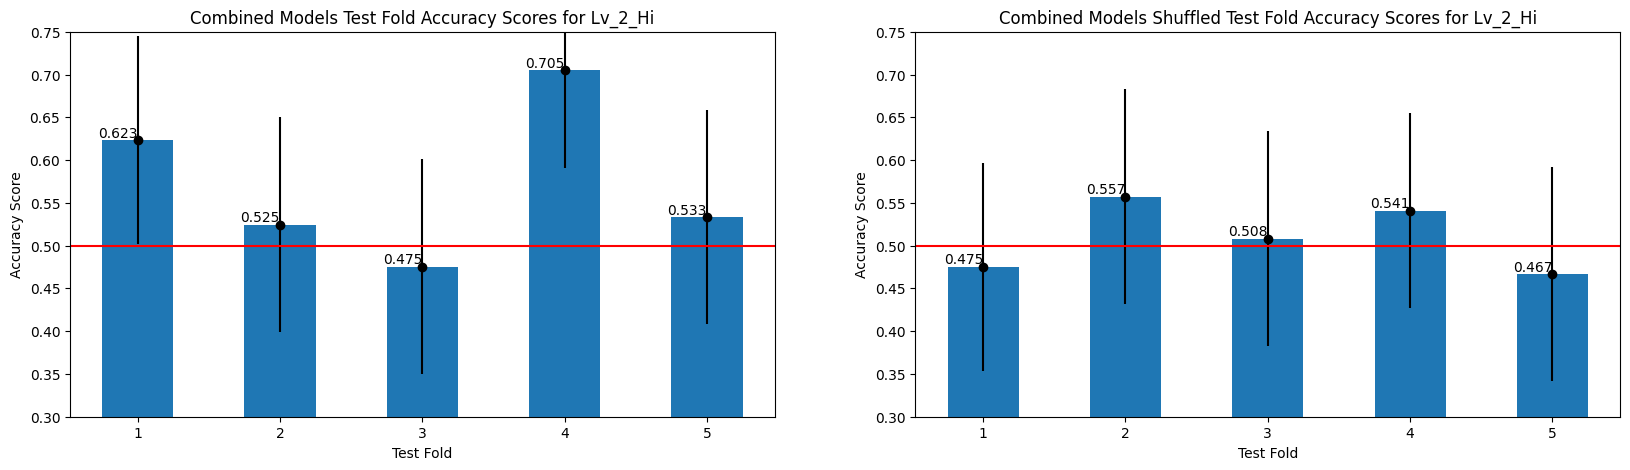

In [ ]:
width = 0.5
x_vals = np.arange(1, 6)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)

errors = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores]

# LASSO Bars
ax1.bar(x_vals, combined_test_scores, width)
for j in x_vals - 1:
    ax1.text(j + 1, combined_test_scores[j], round(combined_test_scores[j], 3), ha = "right", va = "bottom")

# Add Error Bars
ax1.errorbar(x_vals, combined_test_scores, yerr = errors, fmt = "o", c = "black")
ax1.axhline(y = 0.5, color = "r")

ax1.set_ylim([0.3, 0.75])
ax1.set_xlabel("Test Fold")
ax1.set_ylabel("Accuracy Score")
ax1.set_title("Combined Models Test Fold Accuracy Scores for Lv_2_Hi")

errors_shuffled = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores_shuffled]

# LASSO Bars
ax2.bar(x_vals, combined_test_scores_shuffled, width)
for j in x_vals - 1:
    ax2.text(j + 1, combined_test_scores_shuffled[j], round(combined_test_scores_shuffled[j], 3), ha = "right", va = "bottom")

# Add Error Bars
ax2.errorbar(x_vals, combined_test_scores_shuffled, yerr = errors, fmt = "o", c = "black")
ax2.axhline(y = 0.5, color = "r")

ax2.set_ylim([0.3, 0.75])
ax2.set_xlabel("Test Fold")
ax2.set_ylabel("Accuracy Score")
ax2.set_title("Combined Models Shuffled Test Fold Accuracy Scores for Lv_2_Hi")

plt.show()

In [30]:
# Gather predictions for each fold
model_type = "LASSO"
outcome_var = "Lv_2_Hi"
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df[outcome_var])):
    # Append predictions for test fold
    SA_2_sensor_predictions["ECG"].append(all_sensor_CV_models[0][outcome_var][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["EDA"].append(all_sensor_CV_models[1][outcome_var][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["EEG"].append(all_sensor_CV_models[2][outcome_var][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["EYE"].append(all_sensor_CV_models[3][outcome_var][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["fNIRS"].append(all_sensor_CV_models[4][outcome_var][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["RSP"].append(all_sensor_CV_models[5][outcome_var][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_2_sensor_predictions["test_fold"].append(outcomes_df[outcome_var].iloc[test_idx].to_list())

for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df[outcome_var])):
    # Append predictions for test fold in shuffled
    SA_2_sensor_predictions_shuffled["ECG"].append(all_sensor_CV_models_shuffled[0][outcome_var][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["EDA"].append(all_sensor_CV_models_shuffled[1][outcome_var][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["EEG"].append(all_sensor_CV_models_shuffled[2][outcome_var][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["EYE"].append(all_sensor_CV_models_shuffled[3][outcome_var][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["fNIRS"].append(all_sensor_CV_models_shuffled[4][outcome_var][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["RSP"].append(all_sensor_CV_models_shuffled[5][outcome_var][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_2_sensor_predictions_shuffled["test_fold"].append(outcomes_df_shuffled[outcome_var].iloc[test_idx].to_list())

In [55]:
combined_test_scores = []
for a in range(5):
    combined_test_scores.append(accuracy_score(
        SA_2_sensor_predictions["test_fold"][a], 
        (SA_2_sensor_predictions["ECG"][a] + 
         SA_2_sensor_predictions["EDA"][a] +
         SA_2_sensor_predictions["EEG"][a] + 
         SA_2_sensor_predictions["EYE"][a] + 
         SA_2_sensor_predictions["fNIRS"][a]) >= 3))
    
combined_test_scores_shuffled = []
for a in range(5):
    combined_test_scores_shuffled.append(accuracy_score(
        SA_2_sensor_predictions_shuffled["test_fold"][a], 
        (SA_2_sensor_predictions_shuffled["ECG"][a] + 
         SA_2_sensor_predictions_shuffled["EDA"][a] +
         SA_2_sensor_predictions_shuffled["EEG"][a] + 
         SA_2_sensor_predictions_shuffled["EYE"][a] + 
         SA_2_sensor_predictions_shuffled["fNIRS"][a]) >= 3))
    

print(combined_test_scores, combined_test_scores_shuffled)

[0.6229508196721312, 0.5245901639344263, 0.47540983606557374, 0.7049180327868853, 0.5333333333333333] [0.47540983606557374, 0.5573770491803278, 0.5081967213114754, 0.5409836065573771, 0.4666666666666667]


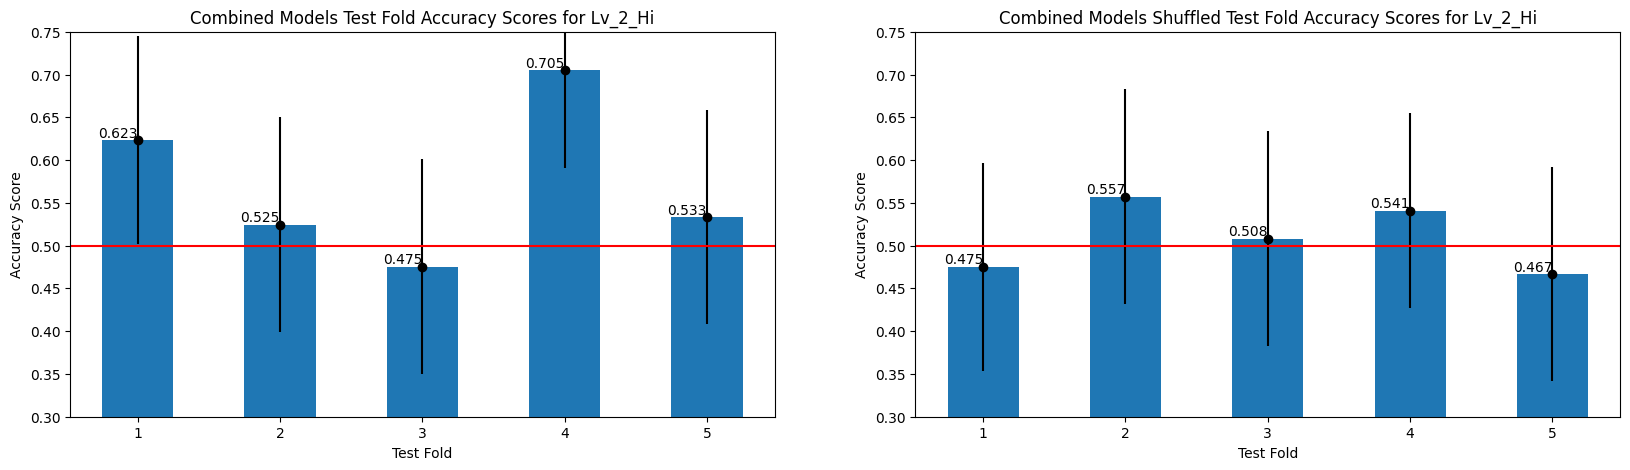

In [61]:
width = 0.5
x_vals = np.arange(1, 6)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)

errors = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores]

# LASSO Bars
ax1.bar(x_vals, combined_test_scores, width)
for j in x_vals - 1:
    ax1.text(j + 1, combined_test_scores[j], round(combined_test_scores[j], 3), ha = "right", va = "bottom")

# Add Error Bars
ax1.errorbar(x_vals, combined_test_scores, yerr = errors, fmt = "o", c = "black")
ax1.axhline(y = 0.5, color = "r")

ax1.set_ylim([0.3, 0.75])
ax1.set_xlabel("Test Fold")
ax1.set_ylabel("Accuracy Score")
ax1.set_title("Combined Models Test Fold Accuracy Scores for Lv_2_Hi")

errors_shuffled = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores_shuffled]

# LASSO Bars
ax2.bar(x_vals, combined_test_scores_shuffled, width)
for j in x_vals - 1:
    ax2.text(j + 1, combined_test_scores_shuffled[j], round(combined_test_scores_shuffled[j], 3), ha = "right", va = "bottom")

# Add Error Bars
ax2.errorbar(x_vals, combined_test_scores_shuffled, yerr = errors, fmt = "o", c = "black")
ax2.axhline(y = 0.5, color = "r")

ax2.set_ylim([0.3, 0.75])
ax2.set_xlabel("Test Fold")
ax2.set_ylabel("Accuracy Score")
ax2.set_title("Combined Models Shuffled Test Fold Accuracy Scores for Lv_2_Hi")

plt.show()

# SA 3

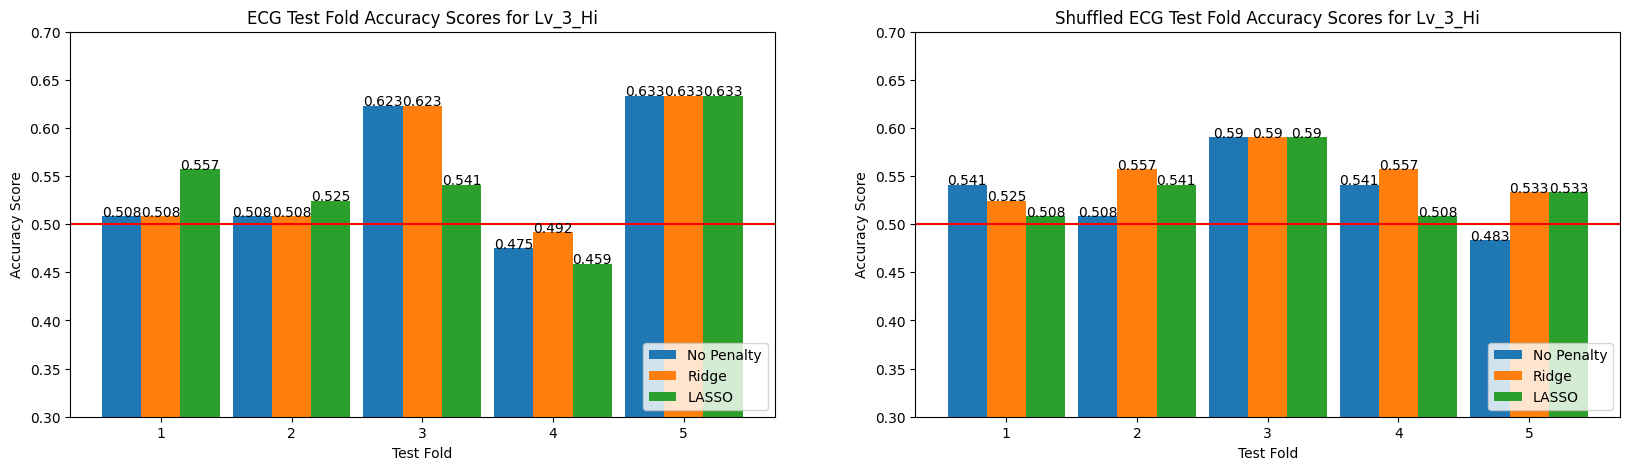

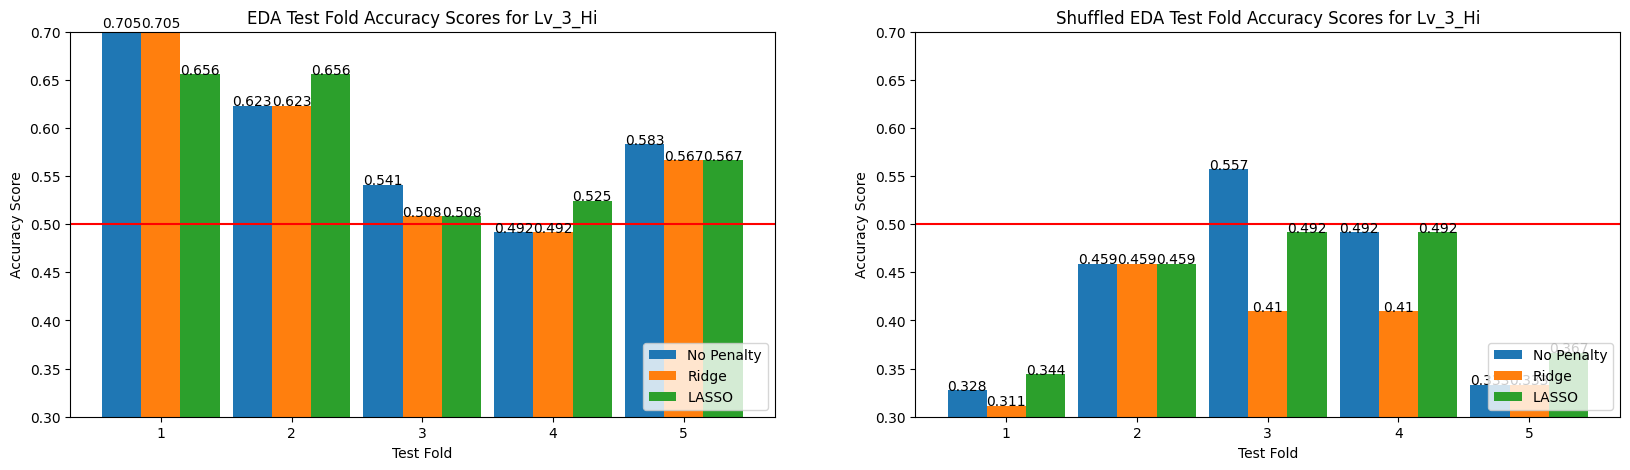

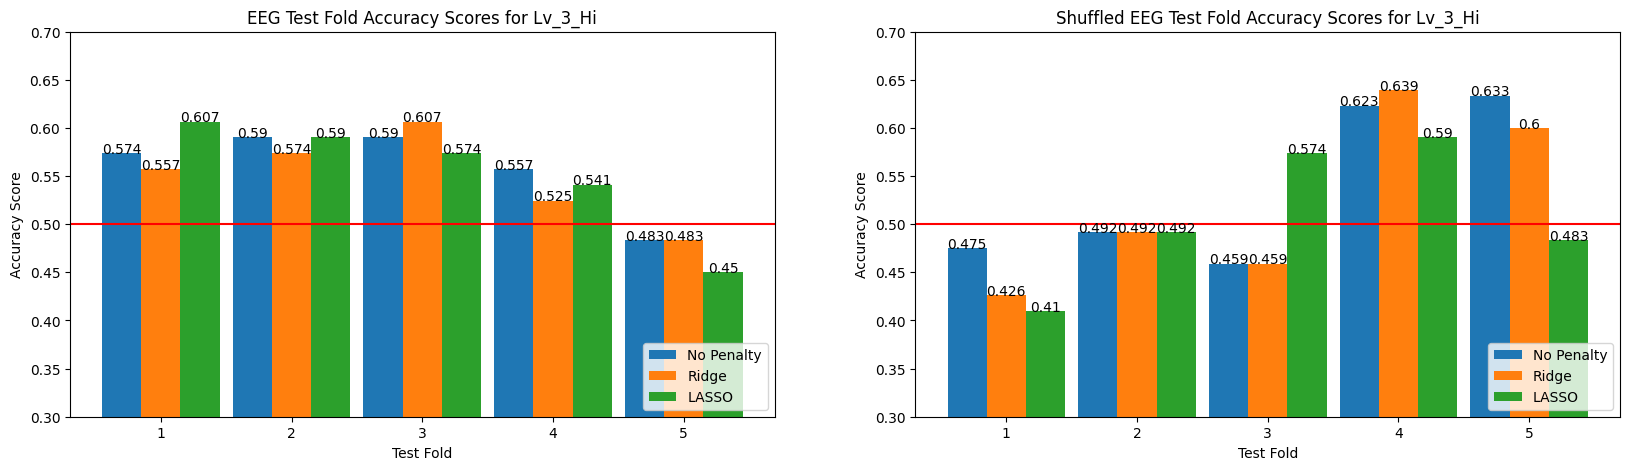

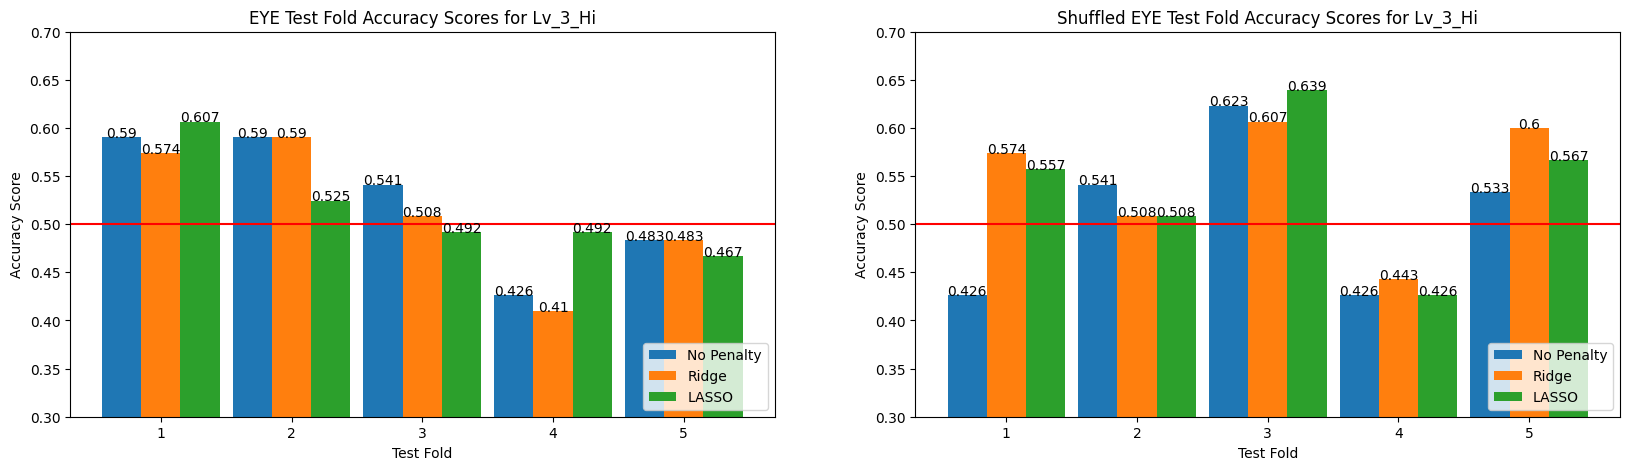

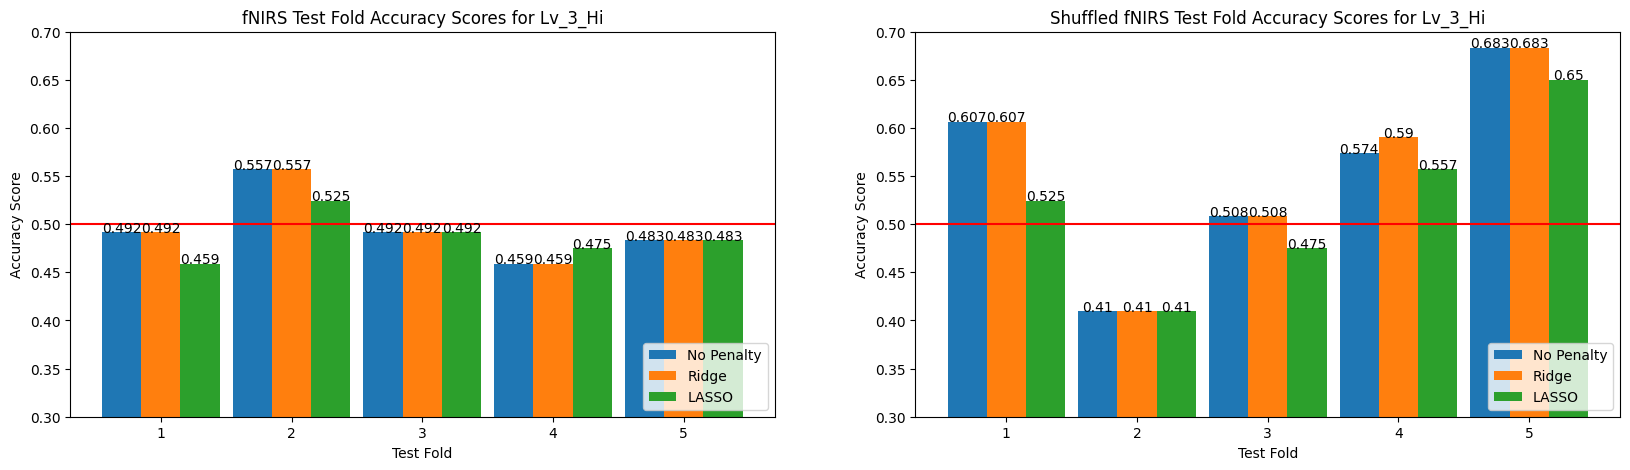

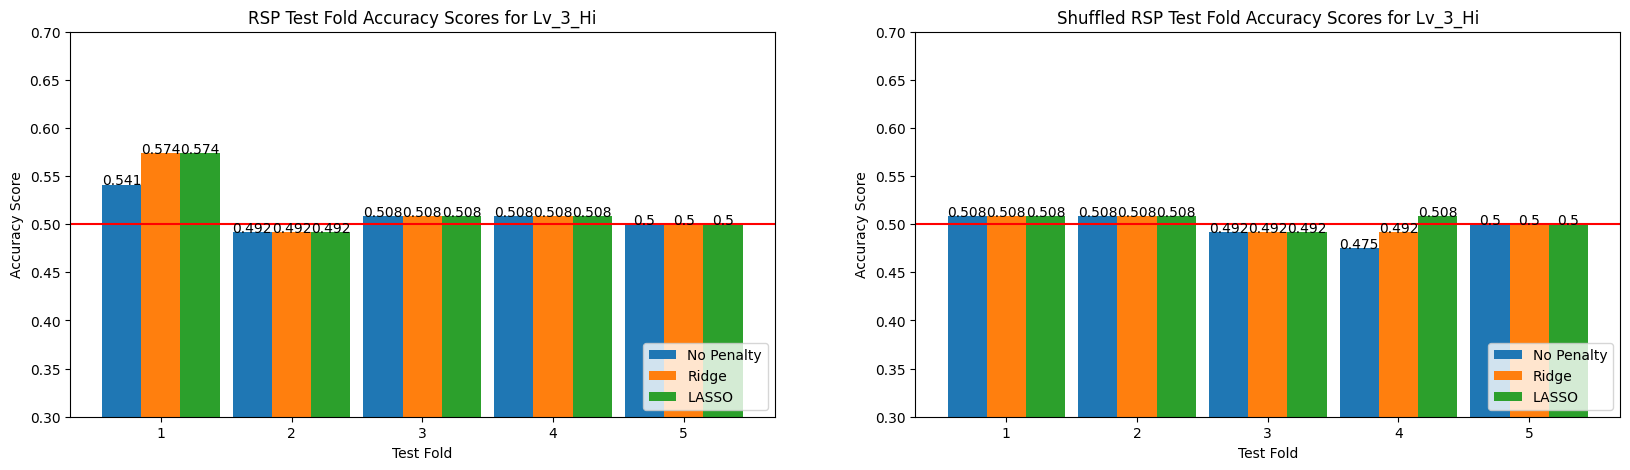

In [62]:
graph_folds(all_sensor_test_scores, all_sensor_test_scores_shuffled, "Lv_3_Hi")

In [ ]:
for model in all_sensor_CV_models[0]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[0]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

10
35
9
39
33

7
9
48
30
6


In [ ]:
for model in all_sensor_CV_models[1]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[1]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

110
84
76
119
116

114
13
0
0
80


In [74]:
for model in all_sensor_CV_models[2]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[2]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

259
248
66
251
86

15
5
1
3
4


In [75]:
for model in all_sensor_CV_models[3]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[3]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

126
5
9
6
89

6
7
5
126
4


In [76]:
for model in all_sensor_CV_models[4]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[4]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

783
282
3387
818
758

375
770
382
372
1462


In [80]:
for model in all_sensor_CV_models[5]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

print()

for model in all_sensor_CV_models_shuffled[5]["Lv_3_Hi"]["LASSO"]:
    print(np.sum(model.coef_ != 0))

16
2
2
2
2

25
2
25
24
2


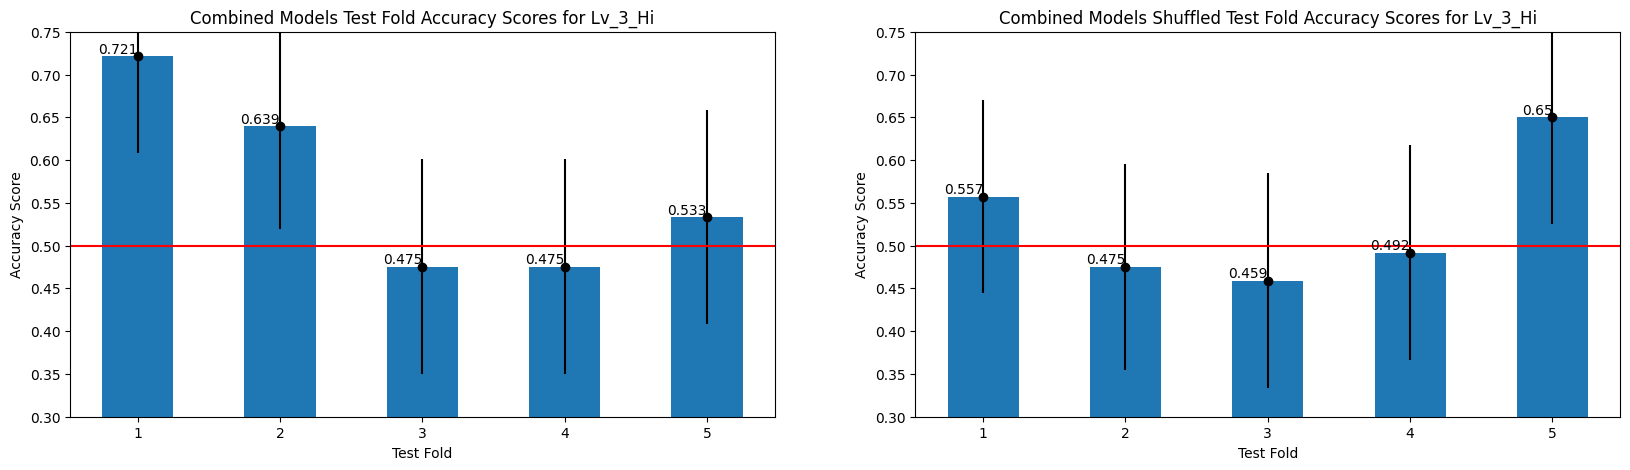

In [73]:
SA_3_sensor_predictions = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

SA_3_sensor_predictions_shuffled = {
    "ECG": [],
    "EDA": [],
    "EEG": [],
    "EYE": [],
    "fNIRS": [],
    "RSP": [],
    "test_fold": []
}

# Gather predictions for each fold
model_type = "LASSO"
outcome_var = "Lv_3_Hi"
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df[outcome_var])):
    # Append predictions for test fold
    SA_3_sensor_predictions["ECG"].append(all_sensor_CV_models[0][outcome_var][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_3_sensor_predictions["EDA"].append(all_sensor_CV_models[1][outcome_var][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_3_sensor_predictions["EEG"].append(all_sensor_CV_models[2][outcome_var][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_3_sensor_predictions["EYE"].append(all_sensor_CV_models[3][outcome_var][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_3_sensor_predictions["fNIRS"].append(all_sensor_CV_models[4][outcome_var][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_3_sensor_predictions["RSP"].append(all_sensor_CV_models[5][outcome_var][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_3_sensor_predictions["test_fold"].append(outcomes_df[outcome_var].iloc[test_idx].to_list())

for i, (train_idx, test_idx) in enumerate(skf.split(ECG_df, outcomes_df[outcome_var])):
    # Append predictions for test fold in shuffled
    SA_3_sensor_predictions_shuffled["ECG"].append(all_sensor_CV_models_shuffled[0][outcome_var][model_type][i].predict(ECG_df.iloc[test_idx, :]))
    SA_3_sensor_predictions_shuffled["EDA"].append(all_sensor_CV_models_shuffled[1][outcome_var][model_type][i].predict(EDA_df.iloc[test_idx, :]))
    SA_3_sensor_predictions_shuffled["EEG"].append(all_sensor_CV_models_shuffled[2][outcome_var][model_type][i].predict(EEG_df.iloc[test_idx, :]))
    SA_3_sensor_predictions_shuffled["EYE"].append(all_sensor_CV_models_shuffled[3][outcome_var][model_type][i].predict(EYE_df.iloc[test_idx, :]))
    SA_3_sensor_predictions_shuffled["fNIRS"].append(all_sensor_CV_models_shuffled[4][outcome_var][model_type][i].predict(fNIRS_df.iloc[test_idx, :]))
    SA_3_sensor_predictions_shuffled["RSP"].append(all_sensor_CV_models_shuffled[5][outcome_var][model_type][i].predict(RSP_df.iloc[test_idx, :]))
    SA_3_sensor_predictions_shuffled["test_fold"].append(outcomes_df_shuffled[outcome_var].iloc[test_idx].to_list())

combined_test_scores = []
for a in range(5):
    combined_test_scores.append(accuracy_score(
        SA_3_sensor_predictions["test_fold"][a], 
        (SA_3_sensor_predictions["ECG"][a] + 
         SA_3_sensor_predictions["EDA"][a] +
         SA_3_sensor_predictions["EEG"][a] + 
         SA_3_sensor_predictions["EYE"][a] + 
         SA_3_sensor_predictions["fNIRS"][a]) >= 3))
    
combined_test_scores_shuffled = []
for a in range(5):
    combined_test_scores_shuffled.append(accuracy_score(
        SA_3_sensor_predictions_shuffled["test_fold"][a], 
        (SA_3_sensor_predictions_shuffled["ECG"][a] + 
         SA_3_sensor_predictions_shuffled["EDA"][a] +
         SA_3_sensor_predictions_shuffled["EEG"][a] + 
         SA_3_sensor_predictions_shuffled["EYE"][a] + 
         SA_3_sensor_predictions_shuffled["fNIRS"][a]) >= 3))
    
width = 0.5
x_vals = np.arange(1, 6)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)

errors = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores]

# LASSO Bars
ax1.bar(x_vals, combined_test_scores, width)
for j in x_vals - 1:
    ax1.text(j + 1, combined_test_scores[j], round(combined_test_scores[j], 3), ha = "right", va = "bottom")

# Add Error Bars
ax1.errorbar(x_vals, combined_test_scores, yerr = errors, fmt = "o", c = "black")
ax1.axhline(y = 0.5, color = "r")

ax1.set_ylim([0.3, 0.75])
ax1.set_xlabel("Test Fold")
ax1.set_ylabel("Accuracy Score")
ax1.set_title("Combined Models Test Fold Accuracy Scores for Lv_3_Hi")

errors_shuffled = [1.96 * np.sqrt(val * (1 - val) / 61) for val in combined_test_scores_shuffled]

# LASSO Bars
ax2.bar(x_vals, combined_test_scores_shuffled, width)
for j in x_vals - 1:
    ax2.text(j + 1, combined_test_scores_shuffled[j], round(combined_test_scores_shuffled[j], 3), ha = "right", va = "bottom")

# Add Error Bars
ax2.errorbar(x_vals, combined_test_scores_shuffled, yerr = errors, fmt = "o", c = "black")
ax2.axhline(y = 0.5, color = "r")

ax2.set_ylim([0.3, 0.75])
ax2.set_xlabel("Test Fold")
ax2.set_ylabel("Accuracy Score")
ax2.set_title("Combined Models Shuffled Test Fold Accuracy Scores for Lv_3_Hi")

plt.show()

# Total SA

TypeError: list indices must be integers or slices, not str

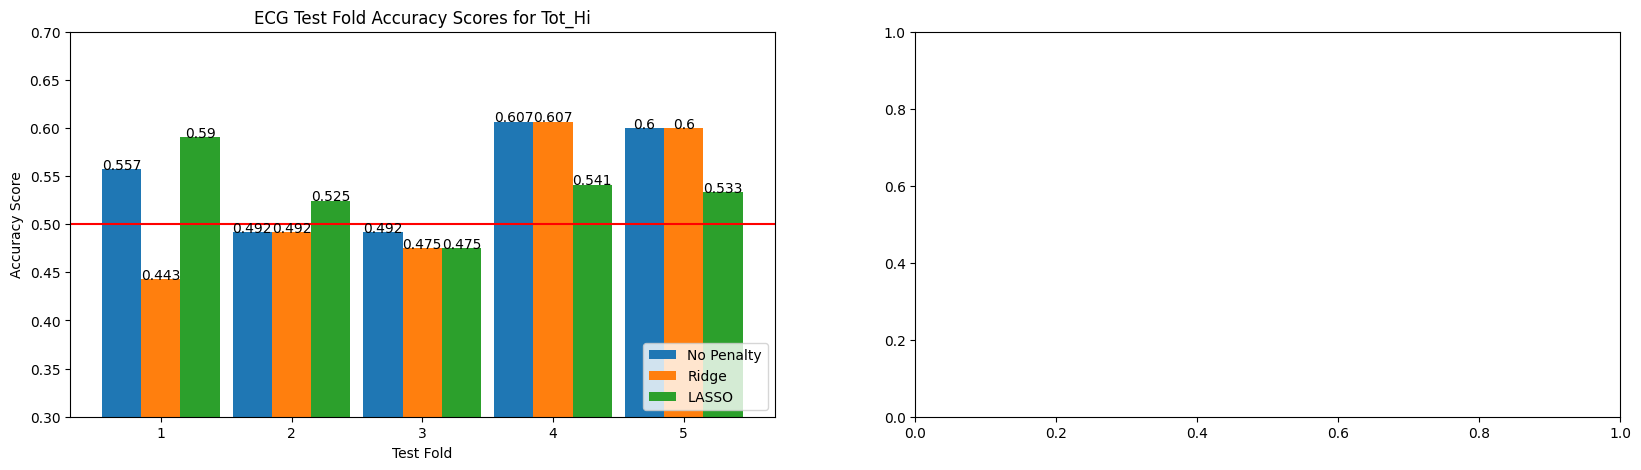

In [81]:
graph_folds(all_sensor_test_scores, all_sensor_test_scores_shuffled, "Tot_Hi")